# Climatology plots for different variables
### Created by Marisol, 6 June 2022

In [1]:
import warnings 
warnings.simplefilter('ignore') 

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
#import fsspec # these libraries help reading cloud data
#import s3fs
#import dask
#from dask.distributed import performance_report, Client, progress
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

In [2]:
lat1, lat2 = 17, 20 
lon1, lon2 = -89,-86.5

In [3]:
def plot_seas(dsa, tit, vm, vx):
    fig=plt.figure(figsize=(5,3),dpi=150)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())
    ax.set_xticks([*range(int(lon1),int(lon2))], crs=ccrs.PlateCarree())
    ax.set_yticks([*range(int(lat1),int(lat2+1))], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')
    dsa.plot(cmap='jet', vmin=vm, vmax=vx)
    plt.plot(-87.71,18.72,'m*')
    plt.plot(-87.83,18.27,'m*')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(tit)
    plt.show()
    
def seas_clim(dsx, var, timevar, off=[0]):
    # seasons
    # secas: feb-may
    # lluvias: jun-sep
    # norte: oct-jan
    a = (dsx[timevar].dt.month>=2)&(dsx[timevar].dt.month<=5)
    secas = dsx[var][a].mean(dim={timevar},keep_attrs=True) + off
    a = (dsx[timevar].dt.month>=6)&(dsx[timevar].dt.month<=9)
    lluvias = dsx[var][a].mean(dim={timevar},keep_attrs=True) + off
    a = (dsx[timevar].dt.month==1)|(dsx[timevar].dt.month>=10)
    norte = dsx[var][a].mean(dim={timevar},keep_attrs=True) + off

    vm = np.min([secas.min().values,lluvias.min().values,norte.min().values])
    vx = np.max([secas.max().values,lluvias.max().values,norte.max().values])
    plot_seas(secas, 'Estacion Seca (Feb-May)', vm, vx)
    plot_seas(lluvias, 'Estacion Lluvias (Jun-Sep)', vm, vx)
    plot_seas(norte, 'Estacion Norte (Oct-Jan)', vm, vx)

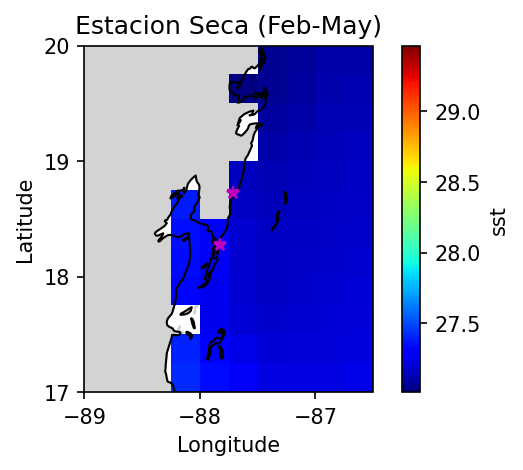

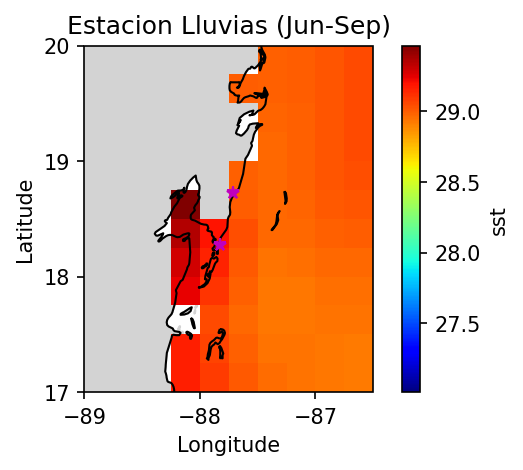

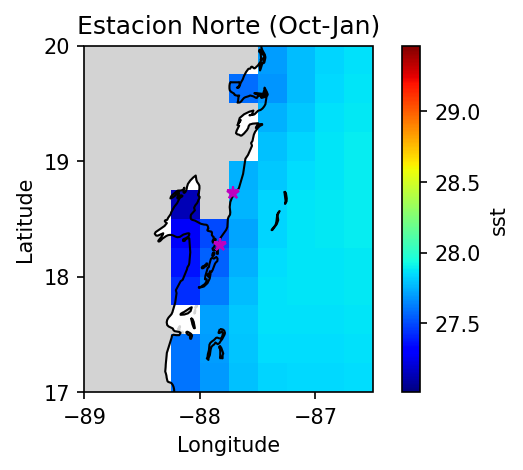

<xarray.Dataset>
Dimensions:  (time: 14337, lat: 12, lon: 10)
Coordinates:
  * time     (time) datetime64[ns] 1981-10-01 1981-10-02 ... 2020-12-31
  * lat      (lat) float32 17.12 17.38 17.62 17.88 ... 19.12 19.38 19.62 19.88
  * lon      (lon) float32 271.1 271.4 271.6 271.9 ... 272.6 272.9 273.1 273.4
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1188, 12, 10), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Sun Jun  5 22:12:50 2022: ncrcat -O -d lat,17.000000,20.0...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    NCO:            netCDF Operators version 4.8.1 (Homepage = http://nco.sf....

In [4]:
# Low resolution SST

ds = xr.open_mfdataset('../data/OISST/*.nc')
ds.close()

seas_clim(ds,'sst','time')
ds

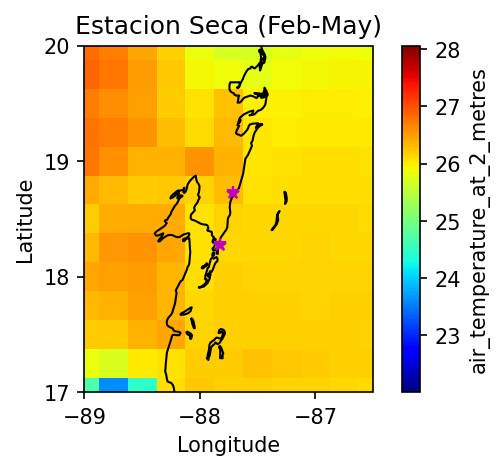

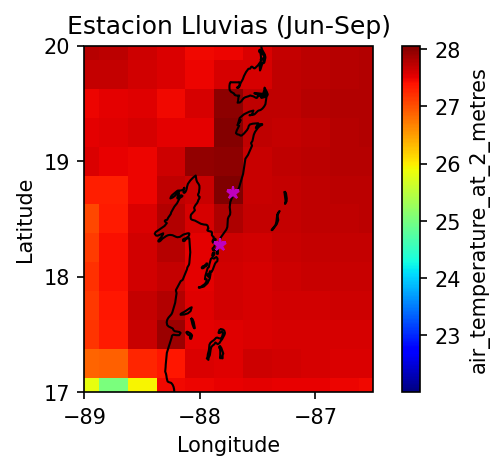

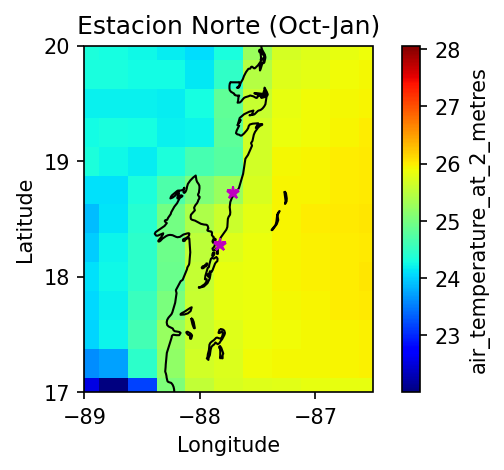

<xarray.Dataset>
Dimensions:                      (lat: 13, lon: 11, time0: 379824)
Coordinates:
  * lat                          (lat) float32 20.0 19.75 19.5 ... 17.25 17.0
  * lon                          (lon) float32 271.0 271.2 271.5 ... 273.2 273.5
  * time0                        (time0) datetime64[ns] 1979-01-01 ... 2022-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(744, 13, 11), meta=np.ndarray>

In [5]:
# Air temp

ds = xr.open_mfdataset('../data/ERA5_AT2m/*.nc')
ds.close()

seas_clim(ds,'air_temperature_at_2_metres','time0',-273.15)
ds

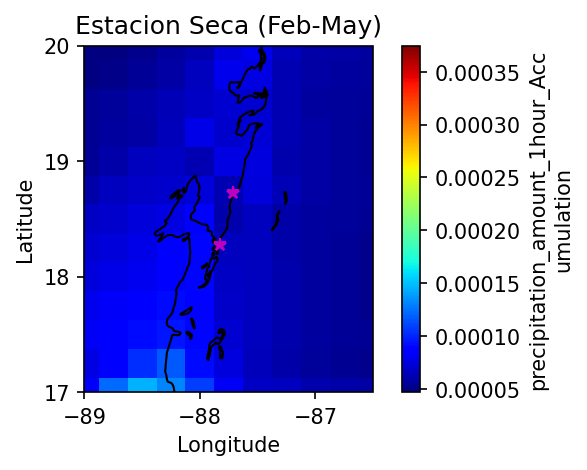

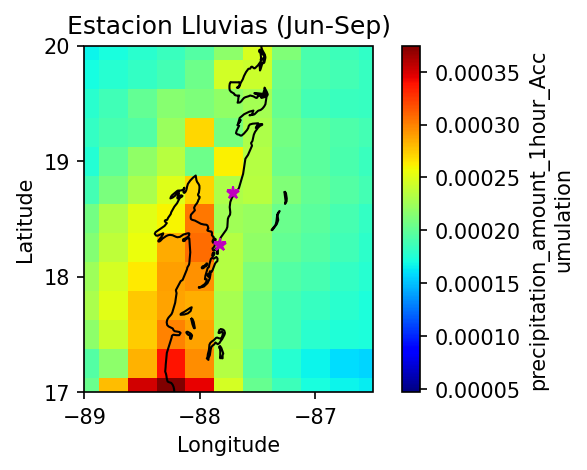

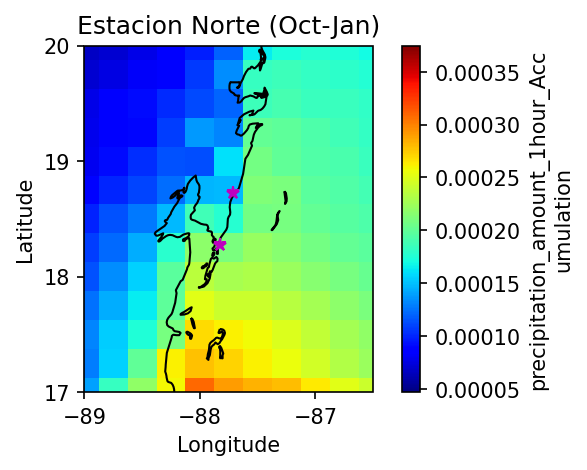

<xarray.Dataset>
Dimensions:                                  (lat: 13, lon: 11, time1: 379817)
Coordinates:
  * lat                                      (lat) float32 20.0 19.75 ... 17.0
  * lon                                      (lon) float32 271.0 271.2 ... 273.5
  * time1                                    (time1) datetime64[ns] 1979-01-0...
Data variables:
    precipitation_amount_1hour_Accumulation  (time1, lat, lon) float32 dask.array<chunksize=(737, 13, 11), meta=np.ndarray>

In [6]:
# Precipitation

ds = xr.open_mfdataset('../data/ERA5_Rain/*.nc')
ds.close()

seas_clim(ds,'precipitation_amount_1hour_Accumulation','time1')
ds

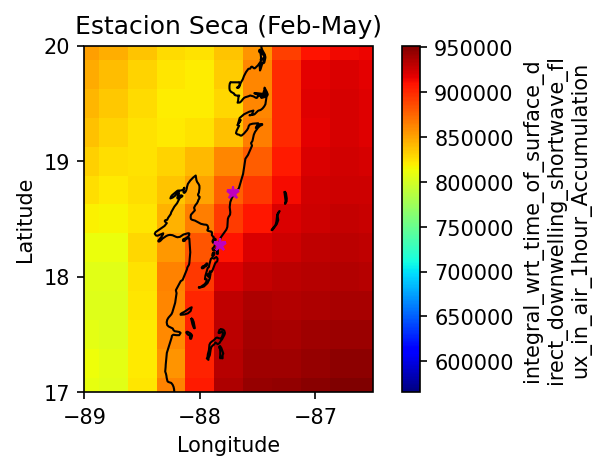

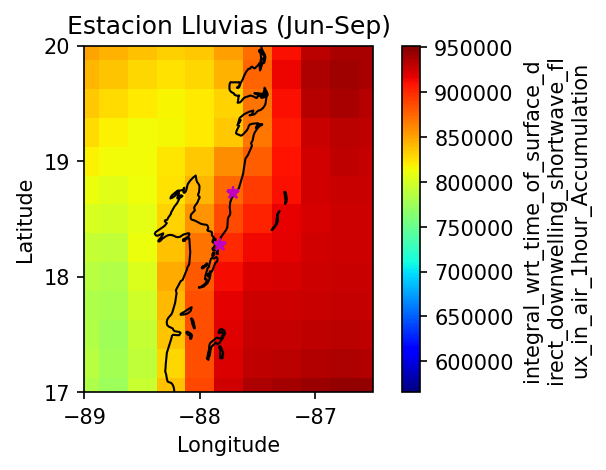

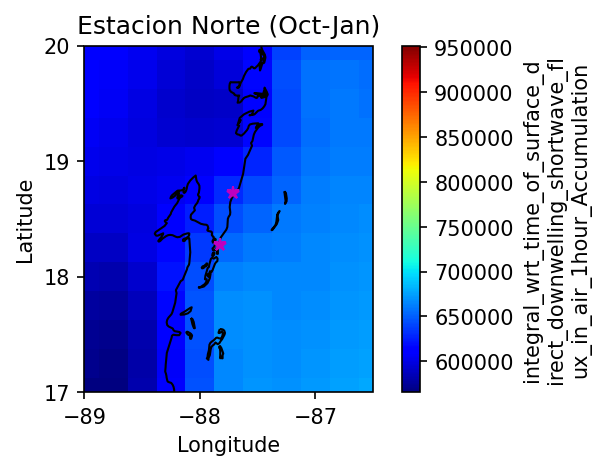

<xarray.Dataset>
Dimensions:                                                                                   (
                                                                                               lat: 13,
                                                                                               lon: 11,
                                                                                               time1: 379817)
Coordinates:
  * lat                                                                                       (lat) float32 ...
  * lon                                                                                       (lon) float32 ...
  * time1                                                                                     (time1) datetime64[ns] ...
Data variables:
    integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation  (time1, lat, lon) float32 dask.array<chunksize=(737, 13, 11), meta=np.ndarray>

In [7]:
# Solar Radiation

ds = xr.open_mfdataset('../data/ERA5_Rad/*.nc')
ds.close()

seas_clim(ds,'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation','time1')
ds

# currents

In [8]:
dsx = xr.open_dataset('../data/Glorys_Currents/GLORYS_1993-01-16_to_2019-12-16_variable_10-0mcurrents.nc')
dsx.close()
timevar='time'
dsx

<xarray.Dataset>
Dimensions:    (time: 324, latitude: 37, longitude: 31)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2019-12-16T12:00:00
  * longitude  (longitude) float32 -89.0 -88.92 -88.83 ... -86.67 -86.58 -86.5
  * latitude   (latitude) float32 17.0 17.08 17.17 17.25 ... 19.83 19.92 20.0
Data variables:
    uo         (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
Attributes: (12/17)
    Conventions:                   CF-1.6
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    area:                          GLOBAL
    comment:                       
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

In [9]:
# Calculate seasonal values
var = 'uo'
a = (dsx[timevar].dt.month>=2)&(dsx[timevar].dt.month<=5)
secas_u = dsx[var][a].mean(dim={timevar},keep_attrs=True) 
a = (dsx[timevar].dt.month>=6)&(dsx[timevar].dt.month<=9)
lluvias_u = dsx[var][a].mean(dim={timevar},keep_attrs=True)
a = (dsx[timevar].dt.month==1)|(dsx[timevar].dt.month>=10)
norte_u = dsx[var][a].mean(dim={timevar},keep_attrs=True) 

var = 'vo'
a = (dsx[timevar].dt.month>=2)&(dsx[timevar].dt.month<=5)
secas_v = dsx[var][a].mean(dim={timevar},keep_attrs=True) 
a = (dsx[timevar].dt.month>=6)&(dsx[timevar].dt.month<=9)
lluvias_v = dsx[var][a].mean(dim={timevar},keep_attrs=True)
a = (dsx[timevar].dt.month==1)|(dsx[timevar].dt.month>=10)
norte_v = dsx[var][a].mean(dim={timevar},keep_attrs=True)

secas = xr.Dataset(
    data_vars=dict(
        uo = (['latitude','longitude'], secas_u.data),
        vo = (['latitude','longitude'], secas_v.data),
    ),
    coords = dict(
        longitude = secas_u.longitude,
        latitude = secas_v.latitude,
    ))
lluvias = xr.Dataset(
    data_vars=dict(
        uo = (['latitude','longitude'], lluvias_u.data),
        vo = (['latitude','longitude'], lluvias_v.data),
    ),
    coords = dict(
        longitude = lluvias_u.longitude,
        latitude = lluvias_v.latitude,
    ))
norte = xr.Dataset(
    data_vars=dict(
        uo = (['latitude','longitude'], norte_u.data),
        vo = (['latitude','longitude'], norte_v.data),
    ),
    coords = dict(
        longitude = norte_u.longitude,
        latitude = norte_v.latitude,
    ))

secas['spd'] = np.sqrt(secas.uo**2+secas.vo**2)
lluvias['spd'] = np.sqrt(lluvias.uo**2+lluvias.vo**2)
norte['spd'] = np.sqrt(norte.uo**2+norte.vo**2)

vm = np.min([secas['spd'].min().values,lluvias['spd'].min().values,norte['spd'].min().values])
vx = np.max([secas['spd'].max().values,lluvias['spd'].max().values,norte['spd'].max().values])

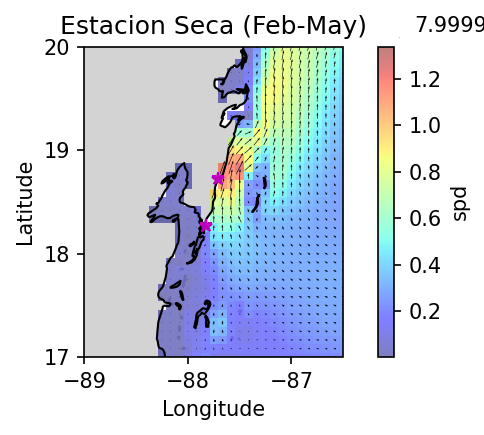

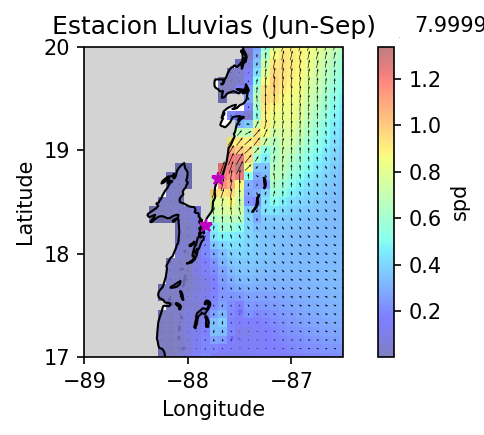

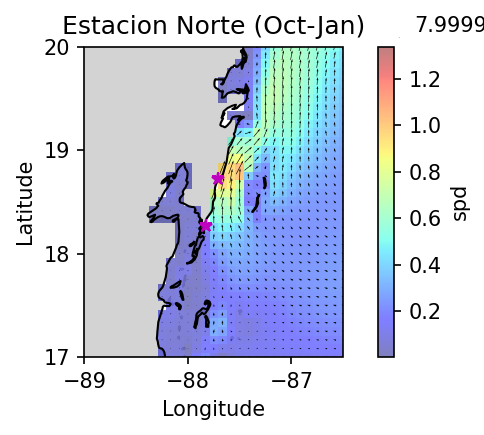

In [10]:

def plot_vseas(dsa, tit, vm, vx):
    fig=plt.figure(figsize=(5,3),dpi=150)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())
    ax.set_xticks([*range(int(lon1),int(lon2))], crs=ccrs.PlateCarree())
    ax.set_yticks([*range(int(lat1),int(lat2+1))], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')
    
    dsa['spd'].plot(cmap='jet', vmin=vm, vmax=vx, alpha=0.5)
    dsa.plot.quiver('longitude','latitude','uo','vo')
    plt.plot(-87.71,18.72,'m*')
    plt.plot(-87.83,18.27,'m*')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(tit)
    plt.tight_layout()
    plt.show()
    
plot_vseas(secas, 'Estacion Seca (Feb-May)', vm, vx)
plot_vseas(lluvias, 'Estacion Lluvias (Jun-Sep)', vm, vx)
plot_vseas(norte, 'Estacion Norte (Oct-Jan)', vm, vx)

# winds 

In [11]:
ds1 = xr.open_mfdataset('../data/ERA5_MW10m/*.nc')
ds1.close()
timevar='time0'
ds2 = xr.open_mfdataset('../data/ERA5_ZW10m/*.nc')
ds2.close()
timevar='time0'
dsx = xr.Dataset(
    data_vars=dict(
        vo = (['time0','lat','lon'], ds1.northward_wind_at_10_metres.data),
        uo = (['time0','lat','lon'], ds2.eastward_wind_at_10_metres.data),
    ),
    coords = dict(
        time0 = ds1.time0,
        lon = ds1.lon,
        lat = ds1.lat,
    ))
dsx['wspd']= np.sqrt(dsx.uo**2+dsx.vo**2)
dsx

<xarray.Dataset>
Dimensions:  (time0: 379824, lat: 13, lon: 11)
Coordinates:
  * time0    (time0) datetime64[ns] 1979-01-01 ... 2022-04-30T23:00:00
  * lon      (lon) float32 271.0 271.2 271.5 271.8 ... 272.8 273.0 273.2 273.5
  * lat      (lat) float32 20.0 19.75 19.5 19.25 19.0 ... 17.75 17.5 17.25 17.0
Data variables:
    vo       (time0, lat, lon) float32 dask.array<chunksize=(744, 13, 11), meta=np.ndarray>
    uo       (time0, lat, lon) float32 dask.array<chunksize=(744, 13, 11), meta=np.ndarray>
    wspd     (time0, lat, lon) float32 dask.array<chunksize=(744, 13, 11), meta=np.ndarray>

In [12]:
var = 'uo'
a = (dsx[timevar].dt.month>=2)&(dsx[timevar].dt.month<=5)
secas_u = dsx[var][a].mean(dim={timevar},keep_attrs=True) 
a = (dsx[timevar].dt.month>=6)&(dsx[timevar].dt.month<=9)
lluvias_u = dsx[var][a].mean(dim={timevar},keep_attrs=True)
a = (dsx[timevar].dt.month==1)|(dsx[timevar].dt.month>=10)
norte_u = dsx[var][a].mean(dim={timevar},keep_attrs=True) 

var = 'vo'
a = (dsx[timevar].dt.month>=2)&(dsx[timevar].dt.month<=5)
secas_v = dsx[var][a].mean(dim={timevar},keep_attrs=True) 
a = (dsx[timevar].dt.month>=6)&(dsx[timevar].dt.month<=9)
lluvias_v = dsx[var][a].mean(dim={timevar},keep_attrs=True)
a = (dsx[timevar].dt.month==1)|(dsx[timevar].dt.month>=10)
norte_v = dsx[var][a].mean(dim={timevar},keep_attrs=True)

secas = xr.Dataset(
    data_vars=dict(
        uo = (['lat','lon'], secas_u.data),
        vo = (['lat','lon'], secas_v.data),
    ),
    coords = dict(
        lon = secas_u.lon,
        lat = secas_v.lat,
    ))
lluvias = xr.Dataset(
    data_vars=dict(
        uo = (['lat','lon'], lluvias_u.data),
        vo = (['lat','lon'], lluvias_v.data),
    ),
    coords = dict(
        lon = lluvias_u.lon,
        lat = lluvias_v.lat,
    ))
norte = xr.Dataset(
    data_vars=dict(
        uo = (['lat','lon'], norte_u.data),
        vo = (['lat','lon'], norte_v.data),
    ),
    coords = dict(
        lon = norte_u.lon,
        lat = norte_v.lat,
    ))

secas['spd'] = np.sqrt(secas.uo**2+secas.vo**2)
lluvias['spd'] = np.sqrt(lluvias.uo**2+lluvias.vo**2)
norte['spd'] = np.sqrt(norte.uo**2+norte.vo**2)

vm = np.min([secas['spd'].min().values,lluvias['spd'].min().values,norte['spd'].min().values])
vx = np.max([secas['spd'].max().values,lluvias['spd'].max().values,norte['spd'].max().values])

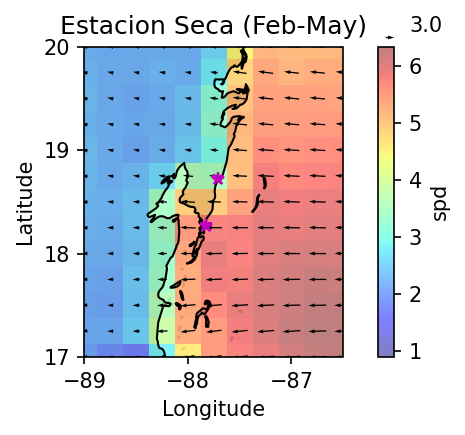

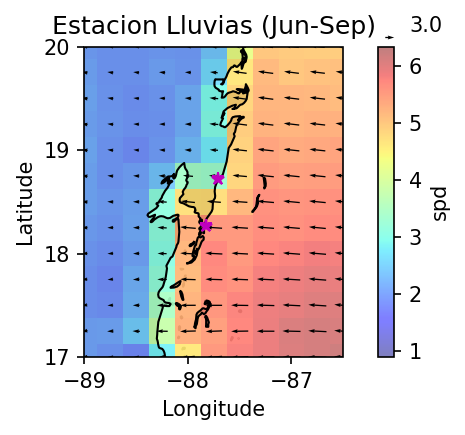

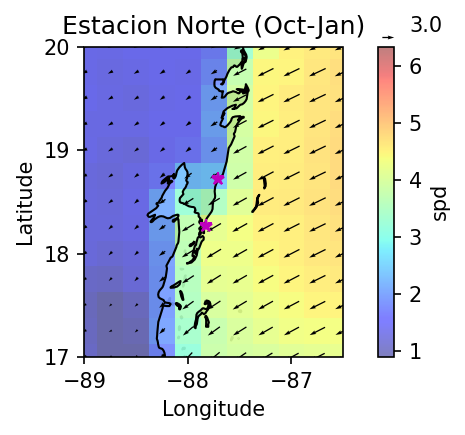

In [13]:
  
def plot_vseas(dsa, tit, vm, vx):
    fig=plt.figure(figsize=(5,3),dpi=150)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())
    ax.set_xticks([*range(int(lon1),int(lon2))], crs=ccrs.PlateCarree())
    ax.set_yticks([*range(int(lat1),int(lat2+1))], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')
    
    dsa['spd'].plot(cmap='jet', vmin=vm, vmax=vx, alpha=0.5)
    dsa.plot.quiver('lon','lat','uo','vo')
    plt.plot(-87.71,18.72,'m*')
    plt.plot(-87.83,18.27,'m*')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(tit)
    plt.tight_layout()
    plt.show()
    
plot_vseas(secas, 'Estacion Seca (Feb-May)', vm, vx)
plot_vseas(lluvias, 'Estacion Lluvias (Jun-Sep)', vm, vx)
plot_vseas(norte, 'Estacion Norte (Oct-Jan)', vm, vx)